In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Loading the path to the folder
DATA_PATH = "/content/drive/MyDrive/studia/Inżynierka/MAIN/"

In [33]:
# Loading the prepared dataset
data = pd.read_csv(DATA_PATH + 'PreparedDataset.csv', low_memory=False)
data['Datetime'] = pd.to_datetime(data['Datetime'], utc=True)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3483 entries, 0 to 3482
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   Datetime  3483 non-null   datetime64[ns, UTC]
 1   Close     3483 non-null   float64            
 2   Returns   3483 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(2)
memory usage: 81.8 KB
None


In [15]:
data.head()

,Datetime,Close,Returns
0,2022-10-31 14:30:00+00:00,153.300003,0.54
1,2022-10-31 15:30:00+00:00,153.979996,0.44
2,2022-10-31 16:30:00+00:00,153.949997,-0.02
3,2022-10-31 17:30:00+00:00,153.770004,-0.12
4,2022-10-31 18:30:00+00:00,153.339996,-0.28


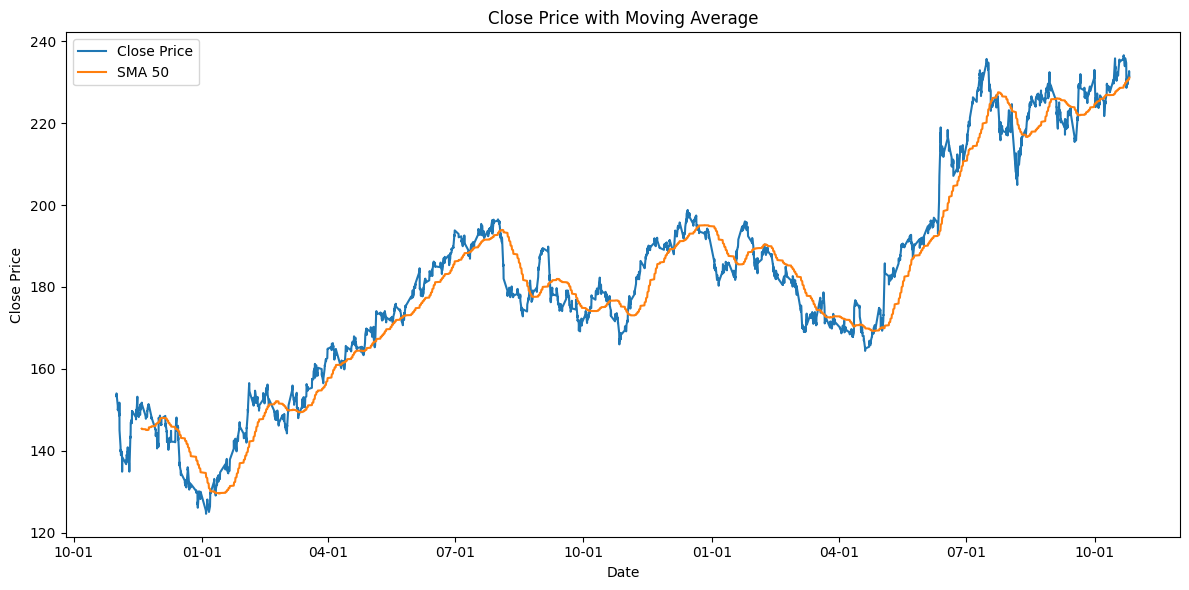

In [29]:
import matplotlib.dates as mdates

sma50 = data.Close.rolling(100).mean()

fig, ax = plt.subplots(figsize=(12, 6))

ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.plot(data.Datetime, data.Close, label="Close Price")
ax.plot(data.Datetime, sma50, label="SMA 50")
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.title("Close Price with Moving Average")
plt.tight_layout()
plt.legend()
plt.show()

## Checking the Stationarity


In [17]:
from statsmodels.tsa.stattools import adfuller

print("Results of Dicky-Fuller Test:")
dftest = adfuller(data['Close'], autolag='AIC')

output = pd.Series(dftest[0:4], index=['ADF Statistic:','p-value:','Lags:','Number of Observations:'])
for key,value in dftest[4].items():
    output['Critical Value (%s):'%key] = value

print(output)

Results of Dicky-Fuller Test:
ADF Statistic                    -0.744812
p-value                           0.834798
#Lags Used                        7.000000
Number of Observations Used    3475.000000
Critical Value (1%)              -3.432233
Critical Value (5%)              -2.862372
Critical Value (10%)             -2.567213
dtype: float64


In [18]:
#p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
#p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

def check_stationarity(timeseries):
    result = adfuller(timeseries)
    dfr = result[0] # Test statistic (ADF value)
    pvalue = result[1] # p-value
    critical_value = result[4]['5%'] # The critical value at the 5% significance level
    if (pvalue <= 0.05) and (dfr < critical_value):
      return True # STATIONARY
    else:
      return False # NON-STATIONARY

# Check if timeseries is stationary
stationarity = check_stationarity(data['Close'])
print(f"Stationarity of the original dataset is: {stationarity}")

# Explore and Differentiate until timeseries is stationary
d = 0
max_iterations = 10
while not stationarity and d < max_iterations:
    d = d + 1
    data.loc[:,'Close'] = data['Close'].diff(periods=d).dropna()
    stationarity = check_stationarity(data['Close'].dropna())

print(f"Optimal value of d: {d}")

Stationarity of the original dataset is: False
Optimal value of d: 1


## Finding the ARIMA terms

We use tools like ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) to determine the values of p, d, and q. The number of lags where ACF cuts off is q, and where PACF cuts off is p.

In [19]:
data.head()

,Datetime,Close,Returns
0,2022-10-31 14:30:00+00:00,NaN,0.54
1,2022-10-31 15:30:00+00:00,0.679993,0.44
2,2022-10-31 16:30:00+00:00,-0.029999,-0.02
3,2022-10-31 17:30:00+00:00,-0.179993,-0.12
4,2022-10-31 18:30:00+00:00,-0.430008,-0.28


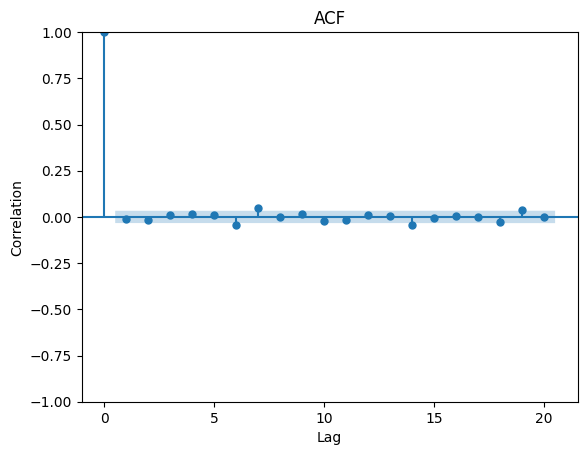

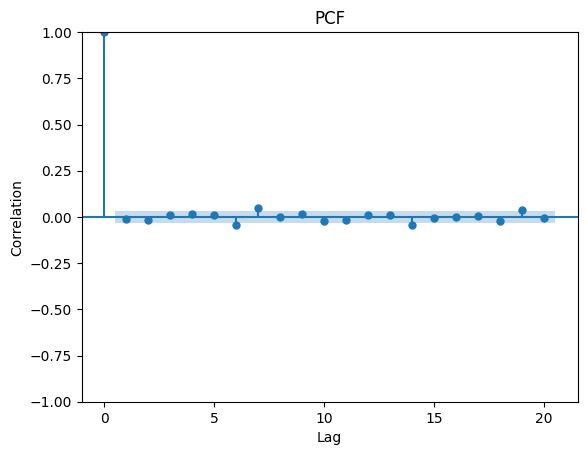

In [20]:
# Plot ACF for returns values (q value)
plot_acf(data['Returns'].dropna(), title='ACF', lags=20)
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

# Plot PCF for returns values (p value)
plot_pacf(data['Returns'].dropna(), title='PCF',lags=20)
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

According to our assumptions we define the value of p for '1' and q for '0'.

In [21]:
# Fit ARIMA (p=1, d=2, q=0)
p, d, q = 1, 2, 0
model = ARIMA(data['Returns'], order = (p, d, q))
model_fit = model.fit()
model_summary = model_fit.summary()
print(model_summary)

                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                 3483
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -5284.167
Date:                Sun, 27 Oct 2024   AIC                          10572.335
Time:                        14:29:58   BIC                          10584.645
Sample:                             0   HQIC                         10576.729
                               - 3483                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6617      0.008    -87.720      0.000      -0.676      -0.647
sigma2         1.2189      0.015     82.169      0.000       1.190       1.248
Ljung-Box (L1) (Q):                 388.69   Jarque-

## Model Diagnostic

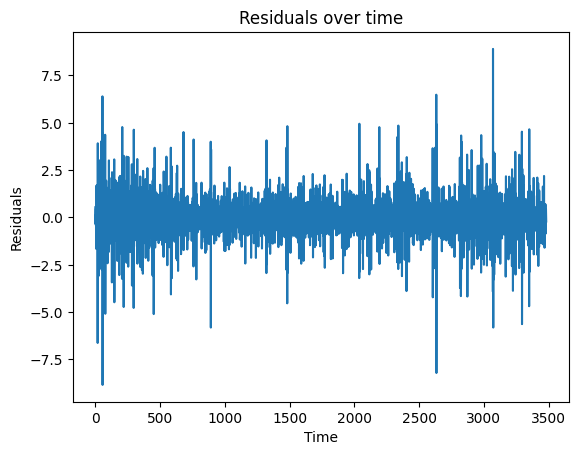

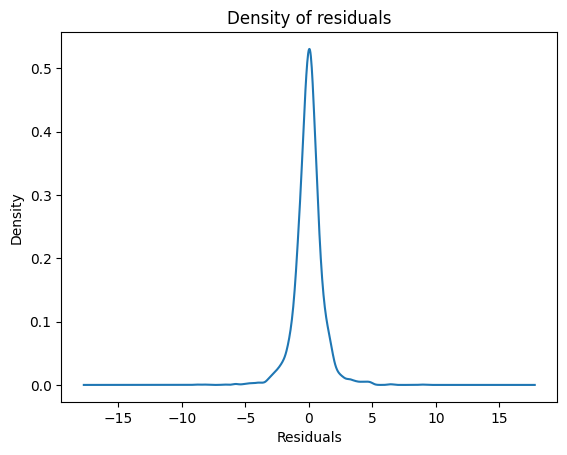

In [22]:
# Checking if the residuals act like white noise- that provides no patterns and no trends
residuals = model_fit.resid
residuals.plot()
plt.title('Residuals over time')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()
residuals.plot(kind='kde')
plt.title('Density of residuals')
plt.xlabel('Residuals')
plt.show()

Based on the visualizations the residuals lack any predictable structure or bias.

In [23]:
# Fit ARIMA (p=1, d=1, q=1)
p, d, q = 1, 1, 1
model = ARIMA(data['Returns'], order = (p, d, q))
model_fit = model.fit()
model_summary = model_fit.summary()
print(model_summary)

                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                 3483
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3153.821
Date:                Sun, 27 Oct 2024   AIC                           6313.642
Time:                        14:30:28   BIC                           6332.108
Sample:                             0   HQIC                          6320.234
                               - 3483                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0119      0.015     -0.812      0.417      -0.040       0.017
ma.L1         -1.0000      0.048    -20.973      0.000      -1.093      -0.907
sigma2         0.3575      0.017     20.443      0.0

## Forecasting

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


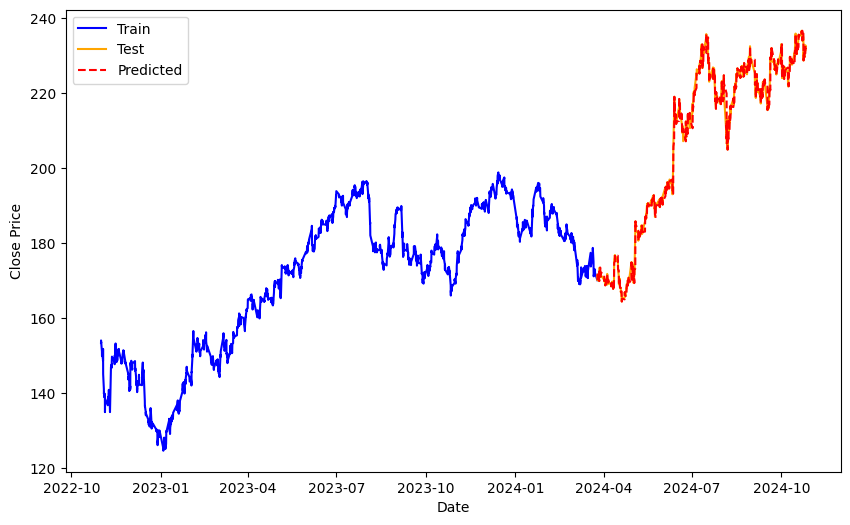

p: 1, d: 1, q: 1
Mean Squared Error: 1.77
Root Mean Squared Error: 1.33
Mean Absolute Percentage Error: 0.37
Mean Absolute Error: 0.78


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# ARIMA parameters
p, d, q = 1, 1, 1
train_size = int(len(data) * 0.7)
train_price, test_price = data['Close'][:train_size], data['Close'][train_size:]

history = [x for x in train_price]
model_predictions = []

# Performing the rolling forecast for each test point
for tp in range(len(test_price)):
    # Fitting ARIMA MODEL on current history
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit()

    # Forecasting the next value and update predictions
    forecast = model_fit.forecast()
    model_predictions.append(forecast[0])

    # Updating the history with the actual value (for true rolling forecast)
    history.append(test_price.iloc[tp])

# Converting model predictions to price levels
predicted_prices = pd.Series(model_predictions, index=test_price.index)

data = data.set_index('Datetime')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(data.index[:train_size], train_price, color="blue", label="Train")
plt.plot(data.index[train_size:], test_price, color="orange", label="Test")
plt.plot(data.index[train_size:], predicted_prices, label="Predicted", color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

print(f'p: {p}, d: {d}, q: {q}')

mse =round(mean_squared_error(test_price, predicted_prices), 2)
rmse =round(np.sqrt(mse),2)
mape =round(np.mean(np.abs((test_price-predicted_prices)/test_price))*100, 2)
mae =round(np.mean(np.abs(test_price -predicted_prices)),2)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:',rmse)
print('Mean Absolute Percentage Error:',mape)
print('Mean Absolute Error:', mae)

In [25]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.0 MB/s eta 0:00:00


## Looking for the best order of parameters for the ARIMA MODEL

In [26]:
from pmdarima import auto_arima

# Using auto_arima to find the best parameters
stepwise_fit = auto_arima(train_price, start_p=0, start_q=0, max_p=5, max_q=5, m=12,
                          seasonal=False, d=1, trace=True, error_action='ignore',
                          suppress_warnings=True, stepwise=True)
print(stepwise_fit.summary())


/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2219.481, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2221.450, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2221.447, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2219.627, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2216.836, Time=1.51 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2217.472, Time=2.98 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2217.460, Time=1.57 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2222.072, Time=1.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2222.139, Time=1.67 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2219.253, Time=5.42 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2216.899, Time=0.59 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 15.460 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 